<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [428]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LinearSegmentedColormap
from statistics import mode

In [429]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)
df.dropna(subset='work_shift', inplace=True) #  Там где нет смены, там нет и данных (знаем)
df.shape

(4240, 24)

### Стили

In [430]:
sns.set_theme(style="darkgrid")
color_for_histplot = '#92B755'
line={"color": "#0b412e", "linewidth": 2}
corporate_colors = ["#92B755", "#133215", "#F3E8D3"]
color_for_line = '#133215'

## Исследование данных на качество


### Исследование типов данных 

In [431]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [432]:
df.head(4)

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0


Типы данных

In [433]:
df.dtypes

datetime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

##### Обработаем datetime для более удобного анализа

In [434]:
df['datetime'] = df['datetime'].apply(lambda x: x.split(' ')[0])
df.head(4)

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0


### Исследование выбросов

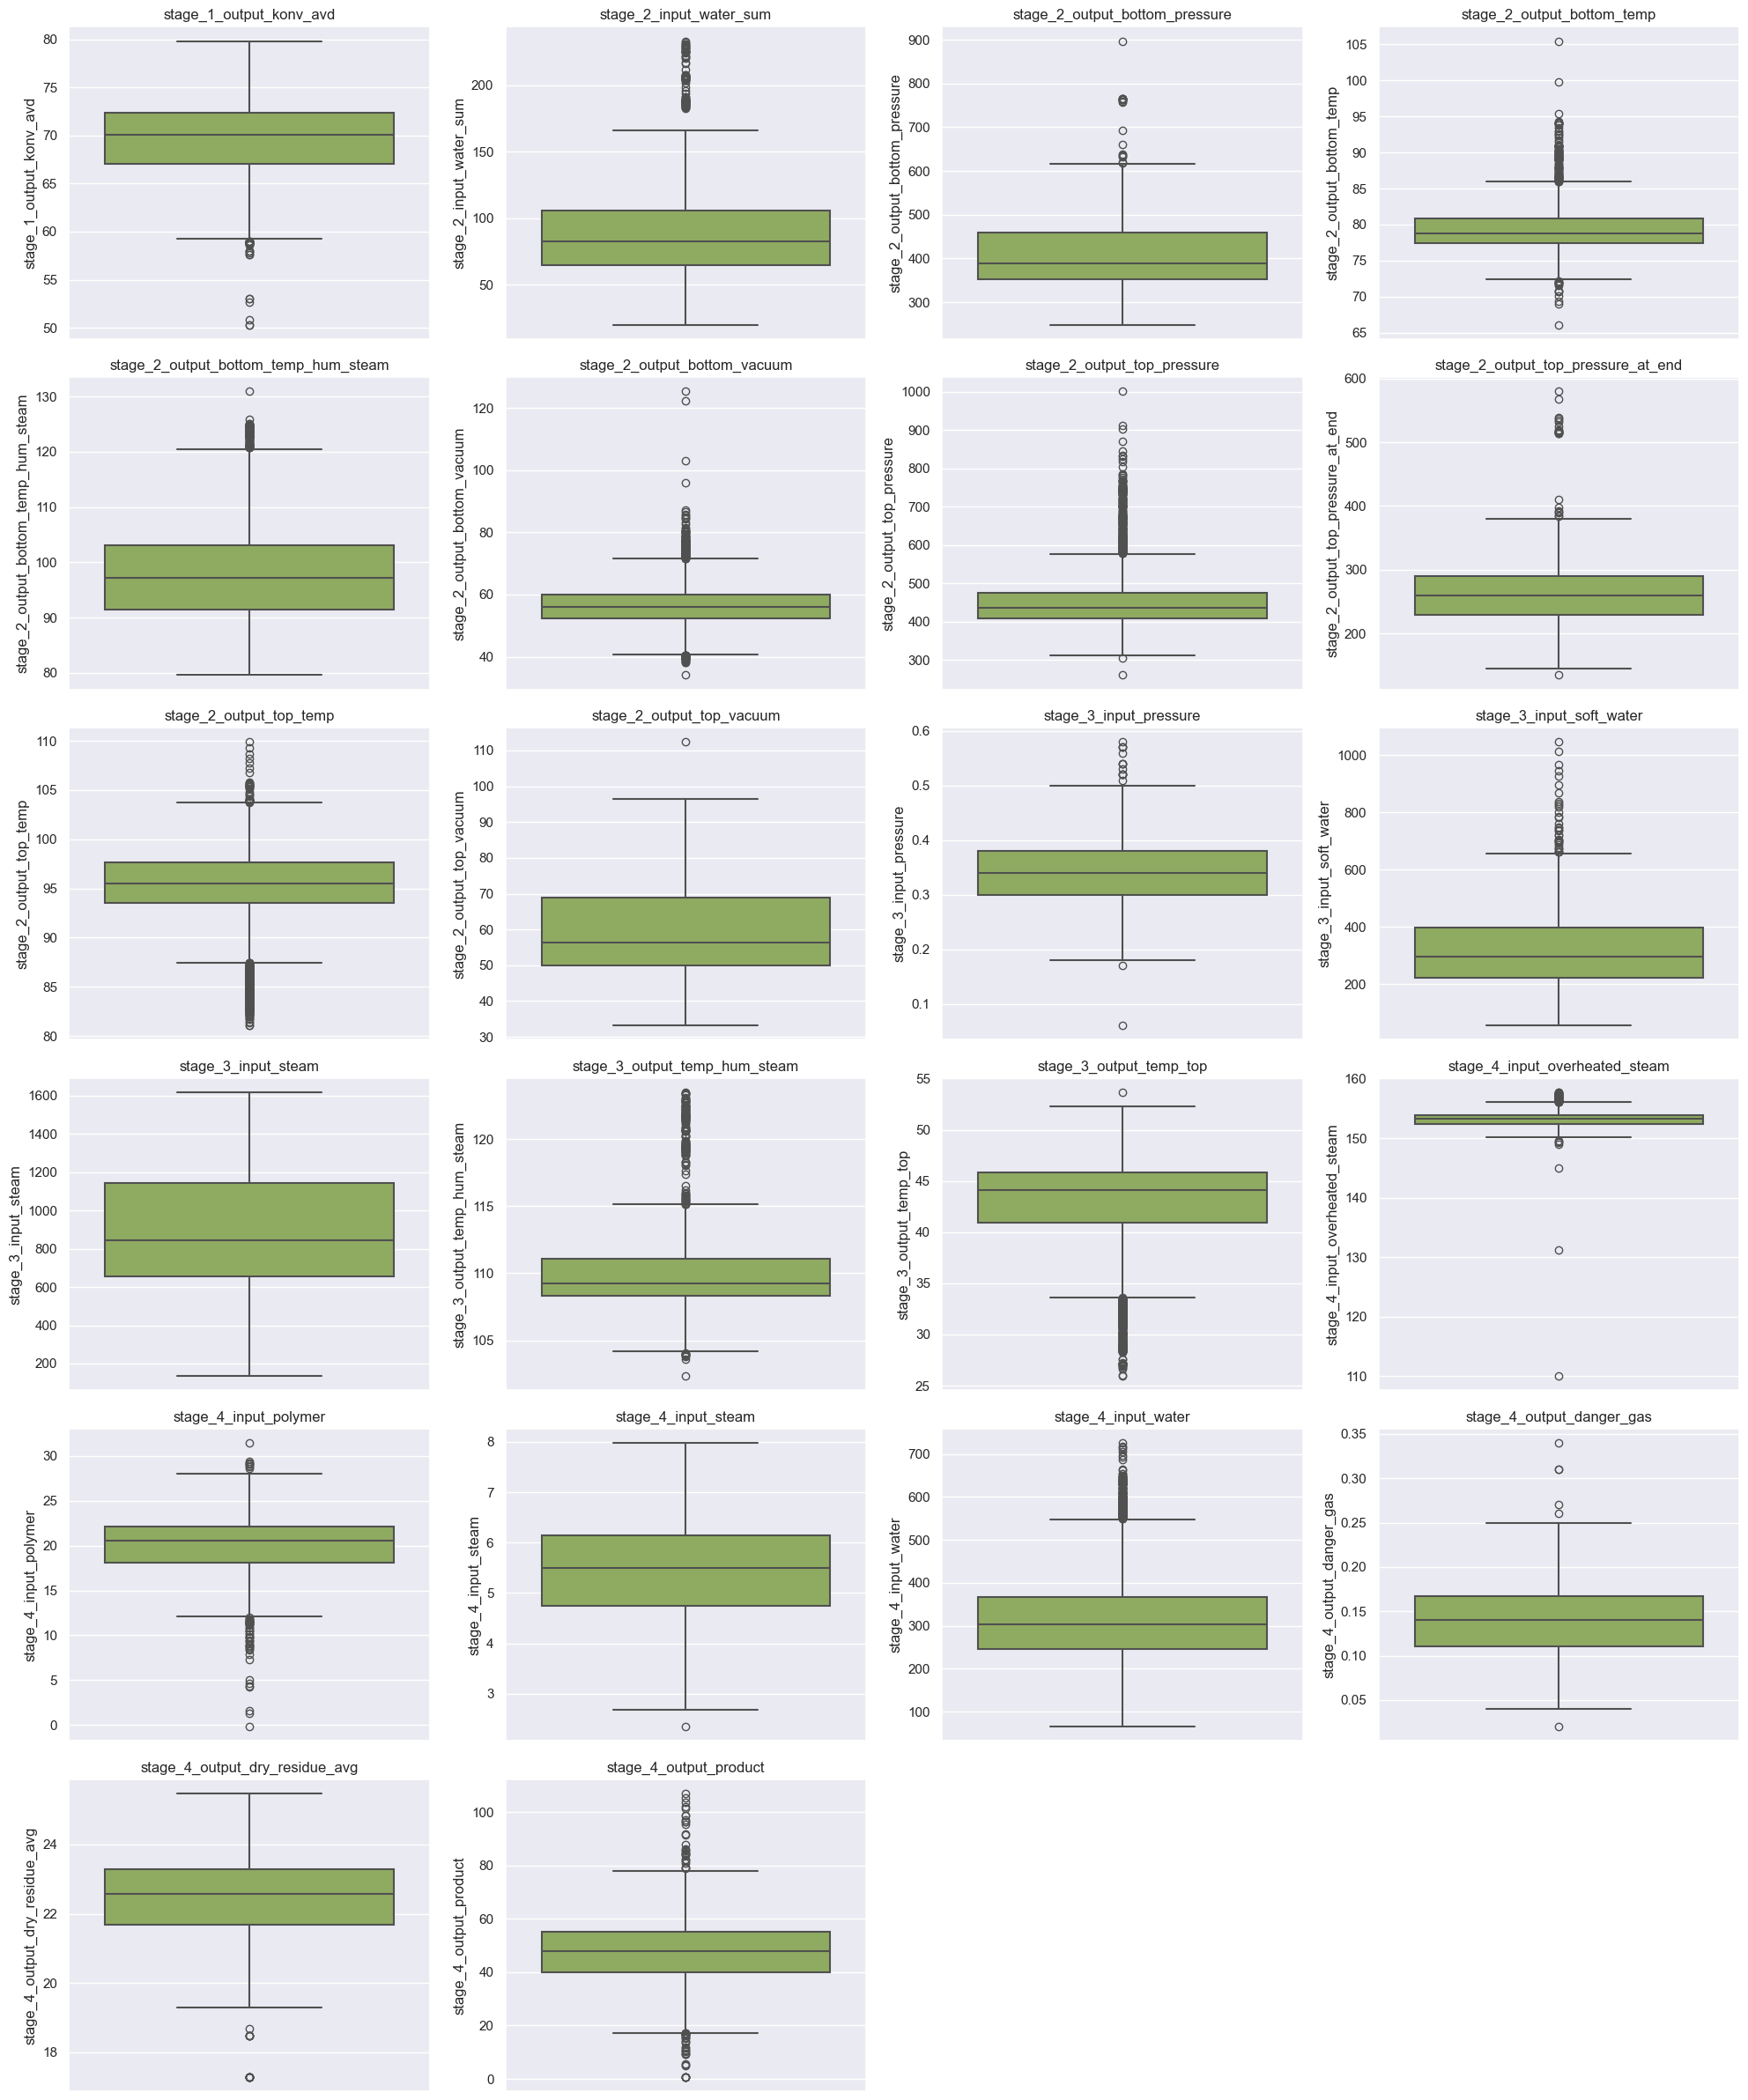

In [435]:
excluded_columns = ['datetime', 'work_shift']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col], color=color_for_histplot, linewidth=1.5)
    plt.title(col)
    plt.tight_layout()

plt.show()

Разделяем на слабые (3 iqr) и супер (6 iqr) выбросы

При анализе показались странными выбросы:  
* stage_2_output_bottom_pressure >800  
* stage_2_output_bottom_temp_hum_steam > 130  
* stage_2_output_bottom_vacuum(нарушение) > 80  
* stage_2_output_top_pressure_at_end(нарушение) > 500  
* stage_2_output_top_vacuum(нарушение) > 80  
* stage_3_input_pressure(нарушение) < 0.1  
* stage_4_input_overheated_steam(нарушение) < 147  
* stage_4_input_polymer < 5  
* stage_4_output_dry_residue_avg < 18  
  
Проверим их, в случае если нет таргета (данных по газу) - удалим

In [436]:
df[df['stage_2_output_bottom_pressure'] > 800]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
3432,2022-06-19,67.33,61.36,897.29,105.46,105.31,73.73,830.38,301.13,106.78,...,108.33,44.92,152.95,13.72,5.47,305.4,NaN,22.98,34.19,1.0


In [437]:
df[df['stage_2_output_bottom_temp_hum_steam'] > 130]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
487,2021-03-11,68.63,113.72,470.37,78.82,130.93,54.25,394.83,279.47,99.39,...,109.81,41.15,156.46,21.2,6.08,222.1,NaN,21.28,67.35,1.0


In [438]:
df[df['stage_2_output_bottom_vacuum'] > 80]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
472,2021-03-02,73.63,117.51,554.43,85.77,94.68,85.76,670.33,217.17,95.47,...,108.12,40.29,156.88,11.50,6.48,444.48,NaN,23.38,77.67,1.0
473,2021-03-02,74.93,114.79,660.03,92.55,98.14,122.38,767.24,263.23,99.31,...,107.91,49.24,156.92,4.25,6.58,437.19,0.12,22.18,57.85,1.0
474,2021-03-02,75.03,111.95,692.52,95.39,101.40,125.36,803.84,363.62,102.27,...,107.89,53.65,156.70,8.85,NaN,436.98,NaN,20.88,59.12,1.0
1108,2021-11-18,60.63,105.40,382.60,81.07,92.69,87.29,464.19,347.61,97.94,...,109.03,45.35,153.47,14.33,4.79,293.85,NaN,19.88,63.41,1.0
1109,2021-11-18,60.83,133.72,378.13,80.81,91.26,86.52,457.26,345.53,96.59,...,108.94,47.06,154.31,14.61,4.78,291.37,NaN,19.88,47.47,1.0
1110,2021-11-18,62.83,NaN,371.08,79.72,92.58,83.31,449.16,339.19,97.16,...,108.56,47.22,153.59,14.73,4.78,293.01,NaN,19.88,47.07,1.0
1111,2021-11-18,64.83,124.28,364.03,78.62,93.89,80.10,441.07,332.85,97.73,...,108.18,47.37,152.87,14.86,4.78,294.65,NaN,19.88,46.67,1.0
1112,2021-11-18,64.83,120.88,369.21,79.49,94.64,82.74,447.17,335.71,98.40,...,108.18,46.83,153.15,14.67,4.78,297.00,NaN,19.88,44.47,1.0
1113,2021-11-18,65.63,117.48,374.38,80.37,95.40,85.38,453.27,338.56,99.08,...,108.19,46.28,153.44,14.48,4.78,299.35,0.17,19.88,42.26,1.0
1114,2021-11-18,65.83,117.02,358.26,78.80,94.13,81.56,440.09,323.15,98.16,...,108.10,45.67,153.33,14.13,4.78,303.94,NaN,19.88,49.58,1.0


In [439]:
df[df['stage_2_output_top_pressure_at_end'] > 500]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
829,2021-04-13,68.03,99.10,477.45,77.73,97.23,58.86,341.18,538.40,98.19,...,111.65,45.37,154.60,19.45,6.00,348.59,NaN,23.48,56.29,1.0
830,2021-04-13,68.03,98.49,477.39,77.74,96.78,58.81,343.47,537.92,97.82,...,111.65,46.03,154.48,19.42,6.23,359.51,NaN,23.48,56.12,2.0
831,2021-04-13,65.93,98.04,478.73,77.55,89.10,59.36,342.79,534.62,93.36,...,111.64,46.99,154.99,19.42,6.22,367.54,0.14,23.48,56.30,2.0
832,2021-04-13,65.03,97.60,480.07,77.37,81.42,59.91,342.10,531.32,88.91,...,111.64,47.95,155.50,19.43,6.22,375.57,NaN,23.48,56.47,2.0
833,2021-04-13,65.03,102.69,481.32,77.12,89.66,58.29,336.69,525.25,93.60,...,111.46,47.31,155.16,19.46,6.23,355.10,NaN,23.48,56.63,2.0
834,2021-04-13,65.63,107.77,482.57,76.88,97.91,56.67,331.27,519.18,98.30,...,111.28,46.66,154.83,19.49,6.23,334.63,NaN,23.48,56.78,2.0
838,2021-04-13,68.33,104.98,484.95,76.90,98.63,55.84,331.16,515.43,98.99,...,110.86,46.72,154.82,18.95,6.24,324.10,NaN,23.68,56.00,2.0
839,2021-04-13,68.73,105.04,486.95,76.77,98.74,55.51,329.64,514.59,99.02,...,110.83,47.26,154.79,18.47,6.24,329.46,NaN,23.68,55.23,2.0
840,2021-04-13,69.03,105.10,488.94,76.63,98.85,55.18,NaN,513.76,99.05,...,110.80,47.79,154.76,17.98,6.23,334.82,NaN,23.68,54.45,2.0
841,2021-04-13,69.03,107.19,487.21,76.68,99.27,55.33,329.13,514.41,99.51,...,110.84,47.41,154.73,18.05,6.24,342.06,NaN,23.68,54.62,2.0


In [440]:
df[df['stage_2_output_top_vacuum'] > 80]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
473,2021-03-02,74.93,114.79,660.03,92.55,98.14,122.38,767.24,263.23,99.31,...,107.91,49.24,156.92,4.25,6.58,437.19,0.12,22.18,57.85,1.0
474,2021-03-02,75.03,111.95,692.52,95.39,101.40,125.36,803.84,363.62,102.27,...,107.89,53.65,156.70,8.85,NaN,436.98,NaN,20.88,59.12,1.0
2624,2022-03-11,71.33,24.95,635.63,94.32,99.36,61.89,742.54,317.97,103.88,...,110.60,37.49,153.26,21.26,4.10,219.55,NaN,22.88,37.27,2.0
2625,2022-03-11,71.33,32.43,611.65,94.17,99.11,55.75,717.04,252.75,102.07,...,110.99,38.28,152.99,11.44,4.20,289.23,NaN,22.88,25.75,2.0
2627,2022-03-11,71.23,39.96,609.59,94.04,98.96,48.42,712.19,215.05,100.28,...,111.38,39.72,153.04,11.62,4.25,380.35,NaN,22.88,25.81,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4050,2022-08-15,65.33,78.19,431.87,83.90,110.21,54.95,511.35,223.53,102.35,...,110.69,33.24,150.48,26.56,4.39,686.18,0.13,21.48,27.89,2.0
4295,2022-11-13,65.33,61.24,346.77,77.74,84.63,NaN,376.50,276.97,91.05,...,106.64,33.15,151.74,18.20,5.94,297.06,0.16,21.68,20.83,1.0
4296,2022-11-14,63.83,62.56,396.76,81.35,82.64,69.34,425.00,345.29,93.37,...,106.38,32.37,151.40,16.84,5.85,282.61,0.15,21.68,20.50,2.0
4297,2022-11-14,64.33,53.68,339.99,76.97,84.28,56.18,364.48,278.28,92.94,...,106.44,29.63,152.23,16.87,5.55,256.08,0.17,21.48,19.79,2.0


In [441]:
df[df['stage_3_input_pressure'] < 0.1]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
3497,2022-07-15,64.63,69.46,336.89,76.93,87.41,44.65,421.43,160.75,84.5,...,102.33,43.19,152.28,15.71,5.25,249.56,NaN,20.68,47.91,2.0


In [442]:
df[df['stage_4_input_overheated_steam'] < 147]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
2290,2022-02-12,71.83,62.69,334.45,76.36,112.23,51.60,427.14,231.92,94.34,...,109.32,42.24,144.98,20.69,4.45,138.25,0.12,22.08,24.74,2.0
3456,2022-06-28,72.33,44.78,277.50,66.13,81.60,39.95,438.93,155.93,83.29,...,105.77,50.20,110.04,11.86,3.54,157.04,NaN,21.98,33.22,2.0
3457,2022-06-28,72.33,59.14,290.80,69.32,84.12,41.69,471.81,183.69,86.42,...,105.72,47.22,131.16,11.59,3.54,157.94,NaN,21.98,36.89,2.0


In [443]:
df[df['stage_4_input_polymer'] < 5]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
473,2021-03-02,74.93,114.79,660.03,92.55,98.14,122.38,767.24,263.23,99.31,...,107.91,49.24,156.92,4.25,6.58,437.19,0.12,22.18,57.85,1.0
529,2021-03-16,74.03,90.88,433.48,74.88,117.87,48.22,373.53,279.29,97.27,...,108.79,41.62,156.76,4.67,4.52,222.52,NaN,22.18,58.84,1.0
775,2021-04-05,71.03,165.79,248.76,70.69,91.95,45.84,260.22,221.03,97.43,...,107.56,49.82,154.26,-0.17,4.05,215.97,NaN,22.58,39.79,2.0
1436,2021-12-02,NaN,70.29,320.88,75.06,100.19,49.11,390.72,163.25,90.30,...,108.07,49.10,152.92,1.33,5.95,318.12,NaN,22.28,22.26,2.0
2626,2022-03-11,71.33,39.91,587.67,94.03,98.85,49.62,691.54,187.53,100.26,...,111.38,39.07,152.72,1.61,4.30,358.90,NaN,22.88,14.23,2.0
4188,2022-09-29,68.43,90.94,347.37,75.82,87.39,50.69,567.14,296.28,88.92,...,103.97,44.86,151.46,4.34,2.35,446.27,NaN,20.08,24.51,1.0


In [444]:
df[df['stage_4_output_dry_residue_avg'] < 18]

,datetime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
703,2021-03-29,69.03,81.59,347.78,77.10,119.81,55.71,415.72,305.12,95.28,...,110.08,39.84,155.57,16.94,3.92,142.30,NaN,17.28,55.62,2.0
704,2021-03-29,69.03,80.99,334.39,75.66,118.96,52.12,403.43,293.87,94.99,...,110.05,41.49,155.04,13.37,3.88,129.45,NaN,17.28,54.40,2.0
705,2021-03-29,69.63,80.39,321.00,74.22,118.11,48.52,391.14,282.63,94.70,...,110.01,43.13,154.51,9.80,3.83,116.60,NaN,17.28,53.18,2.0
706,2021-03-29,69.83,80.53,339.78,76.08,119.30,53.28,404.80,297.98,95.21,...,110.30,41.74,154.79,13.80,3.88,131.31,NaN,17.28,54.70,2.0
707,2021-03-29,70.03,80.67,358.55,77.93,120.49,58.03,418.46,313.33,95.73,...,110.59,40.35,155.06,17.80,3.94,146.02,NaN,17.28,56.23,2.0
708,2021-03-29,70.03,81.65,354.33,77.61,116.10,57.06,416.49,309.11,95.63,...,110.51,40.25,154.70,18.01,3.93,174.59,NaN,17.28,55.93,2.0
709,2021-03-29,68.83,82.64,350.10,77.30,111.72,56.08,414.53,304.88,95.53,...,110.43,40.15,154.33,18.22,3.92,203.16,NaN,17.28,55.64,2.0
710,2021-03-29,67.43,82.94,345.70,76.88,107.17,54.91,412.44,301.58,95.30,...,110.34,40.48,154.63,18.03,3.87,172.62,0.11,17.28,55.98,2.0
711,2021-03-29,66.03,83.25,341.30,76.46,102.62,53.74,410.36,298.28,95.07,...,110.24,40.81,154.92,17.84,3.83,142.08,NaN,17.28,56.33,2.0
712,2021-03-29,66.03,81.82,366.08,78.16,103.05,59.77,433.36,323.84,95.48,...,109.87,40.71,154.68,21.53,3.85,142.74,NaN,17.28,64.93,2.0


In [445]:
df = df[~(
    (
        (df['stage_2_output_bottom_pressure'] > 800) |
        (df['stage_2_output_bottom_temp_hum_steam'] > 130) |
        (df['stage_2_output_bottom_vacuum'] > 80) |
        (df['stage_2_output_top_pressure_at_end'] > 500) |
        (df['stage_2_output_top_vacuum'] > 80) |
        (df['stage_3_input_pressure'] < 0.1) |
        (df['stage_4_input_overheated_steam'] < 147) |
        (df['stage_4_input_polymer'] < 5) |
        (df['stage_4_output_dry_residue_avg'] < 18)
    ) & 
    (df['stage_4_output_danger_gas'].isna())
)]

Причины выбросов:  
* Давление - разгерметизация аппарата, > 101 кПа (Равно атмосферному)  
* Остальное - ошибки производства  
  
Количество выбросов в некоторых категориях большое, что говорит о том, что это нормальные условия протекания тех. процесса
Если мы их уберем, то потеряем существенную часть данных, из за чего мы не сможем дать правельный анализ

### Верхние и нижние границы

* stage_2_output_bottom_pressure < 800  
* stage_2_output_bottom_temp_hum_steam < 130  
* stage_2_output_bottom_vacuum(нарушение) < 80  
* stage_2_output_top_pressure_at_end(нарушение) < 500  
* stage_2_output_top_vacuum(нарушение) < 80  
* stage_3_input_pressure(нарушение) > 0.1  
* stage_4_input_overheated_steam(нарушение) > 147  
* stage_4_input_polymer > 5  
* stage_4_output_dry_residue_avg > 18  

###  Аналитический и графический анализ данных

Добавить границы значений. Сделать выводы.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

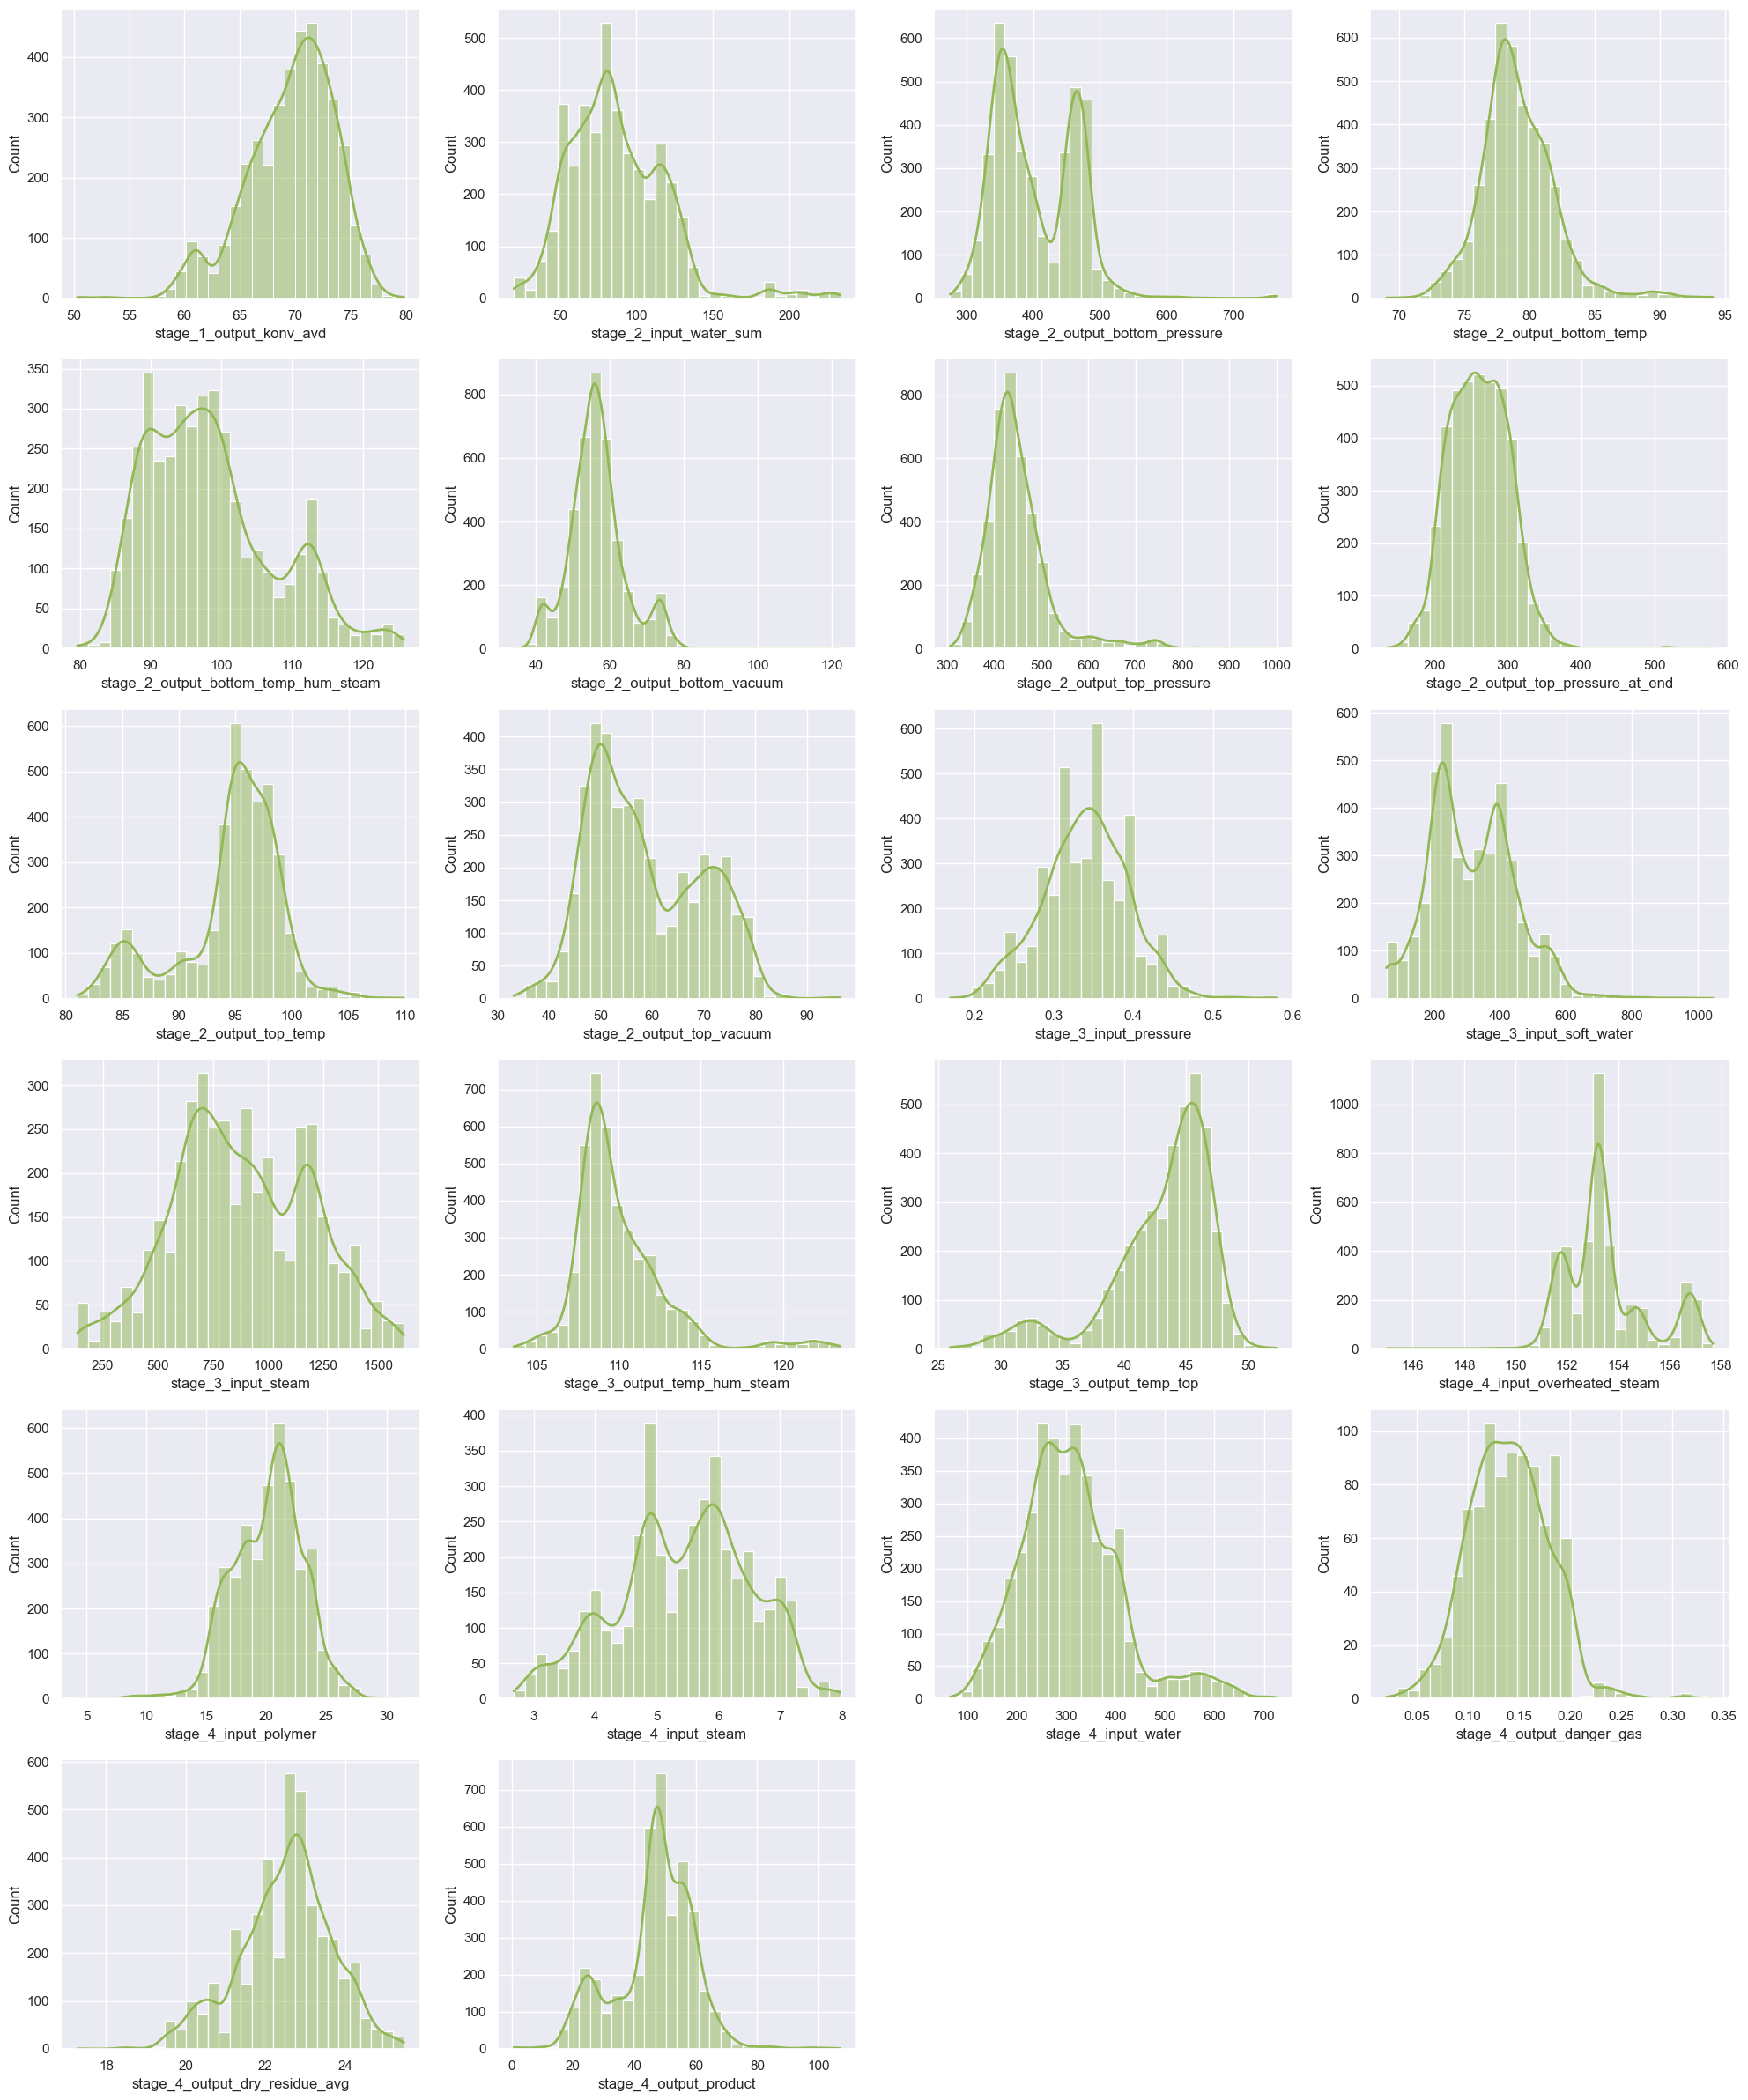

In [446]:
excluded_columns = ['datetime', 'work_shift']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30, color=color_for_histplot, line_kws=line)
    plt.tight_layout()

plt.show()

### Пропуски

In [447]:
df.isna().sum()

datetime                                   0
stage_1_output_konv_avd                   75
stage_2_input_water_sum                   61
stage_2_output_bottom_pressure            59
stage_2_output_bottom_temp                31
stage_2_output_bottom_temp_hum_steam      15
stage_2_output_bottom_vacuum              71
stage_2_output_top_pressure               20
stage_2_output_top_pressure_at_end        14
stage_2_output_top_temp                   44
stage_2_output_top_vacuum                 35
stage_3_input_pressure                    74
stage_3_input_soft_water                  51
stage_3_input_steam                       11
stage_3_output_temp_hum_steam             13
stage_3_output_temp_top                   67
stage_4_input_overheated_steam             9
stage_4_input_polymer                     66
stage_4_input_steam                       82
stage_4_input_water                       80
stage_4_output_danger_gas               3161
stage_4_output_dry_residue_avg             0
stage_4_ou

'stage_4_input_water' - подача воды, в м3  
Вероятно, ошибки или сбои, тк воду точно подавали, распределение не нормальное - используем медиану

310.04846326276464
301.26


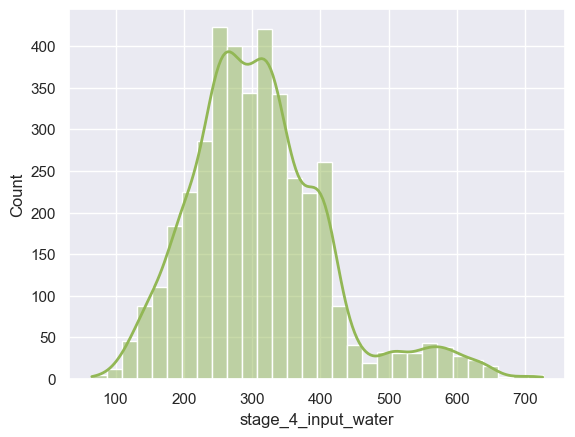

In [448]:
print(df['stage_4_input_water'].mean())
print(df['stage_4_input_water'].median())

sns.histplot(df['stage_4_input_water'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [449]:
df['stage_4_input_water'] = df['stage_4_input_water'].fillna(df['stage_4_input_water'].median())
df['stage_4_input_water'].isna().sum()


0

'stage_4_input_steam' - подача пара, в м3  
Распределение не нормальное - используем медиану

5.431607276351857
5.54


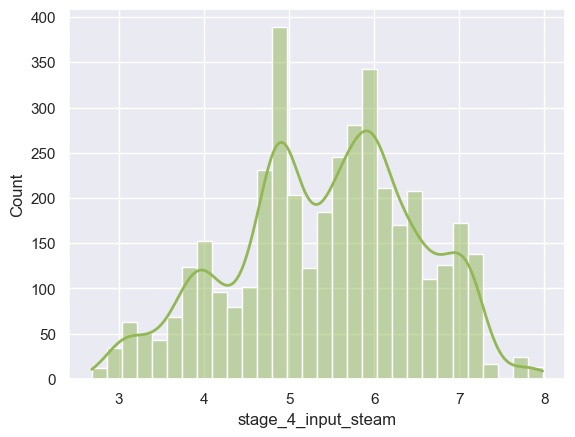

In [450]:
print(df['stage_4_input_steam'].mean())
print(df['stage_4_input_steam'].median())
sns.histplot(df['stage_4_input_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [451]:
df['stage_4_input_steam'] = df['stage_4_input_steam'].fillna(df['stage_4_input_steam'].median())
df['stage_4_input_steam'].isna().sum()

0

'stage_4_input_polymer' - подача полимера, в м3  
Распределение не нормальное - используем медиану

20.14309009679821
20.49


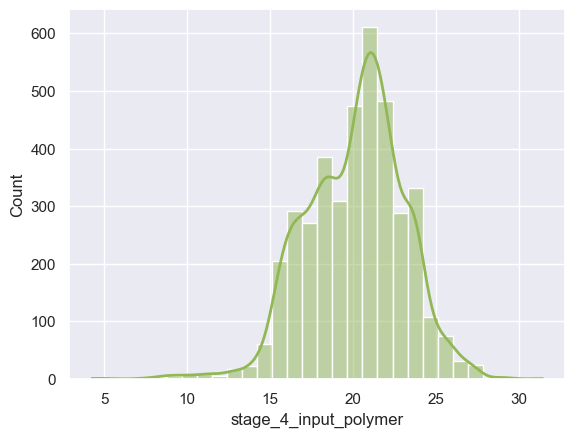

In [452]:
print(df['stage_4_input_polymer'].mean())
print(df['stage_4_input_polymer'].median())
sns.histplot(df['stage_4_input_polymer'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [453]:
df['stage_4_input_polymer'] = df['stage_4_input_polymer'].fillna(df['stage_4_input_polymer'].median())
df['stage_4_input_polymer'].isna().sum()

0

'stage_4_input_overheated_steam' - подача перегретого пара, в м3  
Распределение не нормальное - используем медиану

153.48953010279
153.22


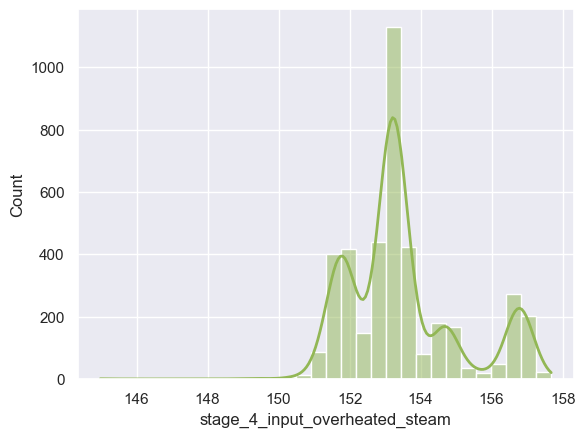

In [454]:
print(df['stage_4_input_overheated_steam'].mean())
print(df['stage_4_input_overheated_steam'].median())
sns.histplot(df['stage_4_input_overheated_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [455]:
df['stage_4_input_overheated_steam'] = df['stage_4_input_overheated_steam'].fillna(df['stage_4_input_overheated_steam'].median())
df['stage_4_input_overheated_steam'].isna().sum()

0

'stage_3_output_temp_top' - температура верха в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану

42.95436941410129
44.16


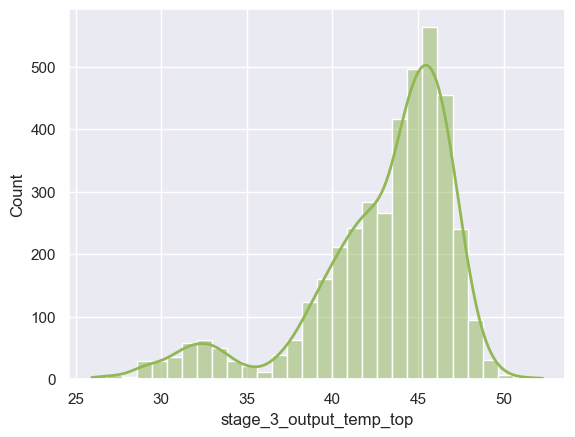

In [456]:
print(df['stage_3_output_temp_top'].mean())
print(df['stage_3_output_temp_top'].median())
sns.histplot(df['stage_3_output_temp_top'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [457]:
df['stage_3_output_temp_top'] = df['stage_3_output_temp_top'].fillna(df['stage_3_output_temp_top'].median())

'stage_3_output_temp_hum_steam' - температура насыщенного пара, в градусах Цельсия  
Распределение не нормальное - используем медиану

109.99299118079374
109.235


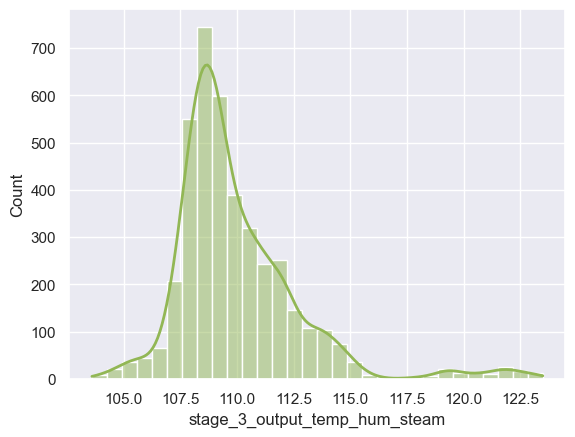

In [458]:
print(df['stage_3_output_temp_hum_steam'].mean())
print(df['stage_3_output_temp_hum_steam'].median())
sns.histplot(df['stage_3_output_temp_hum_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [459]:
df['stage_3_output_temp_hum_steam'] = df['stage_3_output_temp_hum_steam'].fillna(df['stage_3_output_temp_hum_steam'].median())

'stage_3_input_steam'- подаваемый пар, в м3  
Распределение не нормальное - используем медиану 

880.8266723800195
858.975


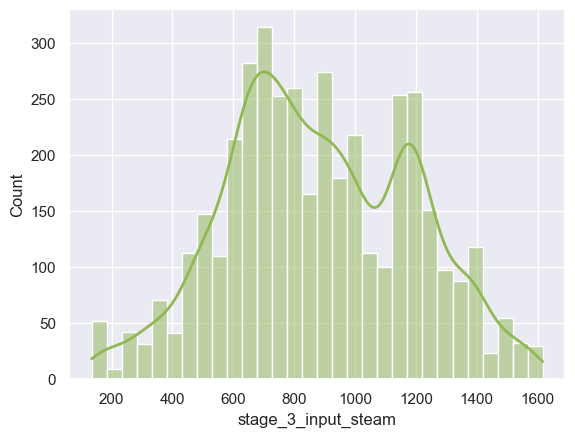

In [460]:
print(df['stage_3_input_steam'].mean())
print(df['stage_3_input_steam'].median())
sns.histplot(df['stage_3_input_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [461]:
df['stage_3_input_steam'] = df['stage_3_input_steam'].fillna(df['stage_3_input_steam'].median())

'stage_3_input_soft_water' - подаваемая смягченная вода, в м3  
Распределение не нормальное - используем медиану

315.2262512363996
298.945


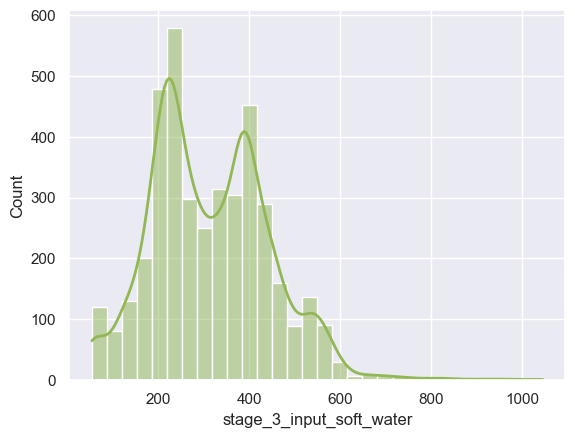

In [462]:
print(df['stage_3_input_soft_water'].mean())
print(df['stage_3_input_soft_water'].median())
sns.histplot(df['stage_3_input_soft_water'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [463]:
df['stage_3_input_soft_water'] = df['stage_3_input_soft_water'].fillna(df['stage_3_input_soft_water'].median())

'stage_3_input_pressure' - подаваемое давление в агрегат, в кПа  
Распределение не нормальное - используем медиану

0.3399850783387217
0.34


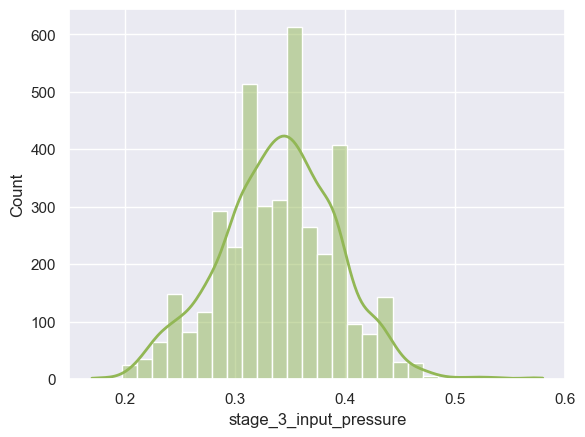

In [464]:
print(df['stage_3_input_pressure'].mean())
print(df['stage_3_input_pressure'].median())
sns.histplot(df['stage_3_input_pressure'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [465]:
df['stage_3_input_pressure'] = df['stage_3_input_pressure'].fillna(df['stage_3_input_pressure'].median())

'stage_2_output_top_vacuum' - вакуум низа в агрегате, в кПа  
Распределение не нормальное - используем медиану

58.51582266009852
56.245000000000005


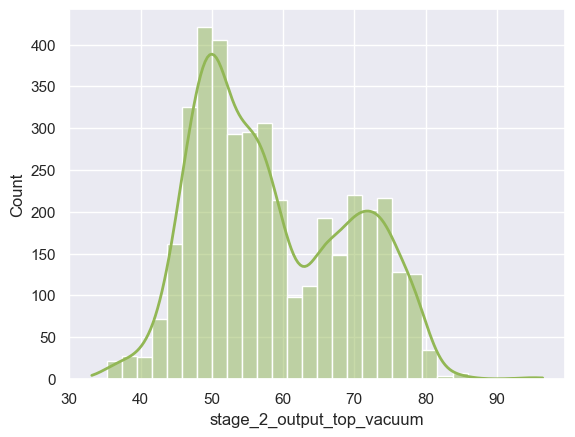

In [466]:
print(df['stage_2_output_top_vacuum'].mean())
print(df['stage_2_output_top_vacuum'].median())
sns.histplot(df['stage_2_output_top_vacuum'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [467]:
df['stage_2_output_top_vacuum'] = df['stage_2_output_top_vacuum'].fillna(df['stage_2_output_top_vacuum'].median())

'stage_2_output_top_temp' - температура низа в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану 

94.55929893853369
95.48


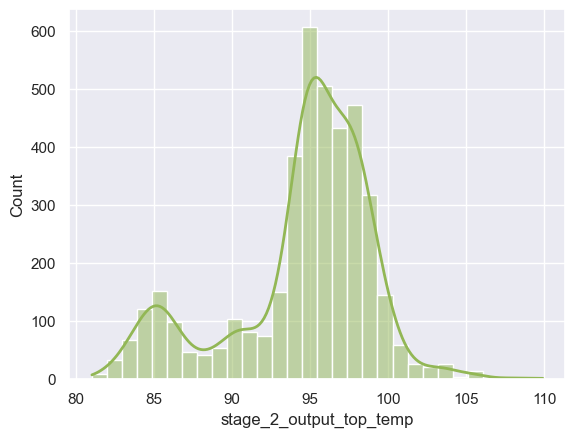

In [468]:
print(df['stage_2_output_top_temp'].mean())
print(df['stage_2_output_top_temp'].median())
sns.histplot(df['stage_2_output_top_temp'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [469]:
df['stage_2_output_top_temp'] = df['stage_2_output_top_temp'].fillna(df['stage_2_output_top_temp'].median())

'stage_2_output_top_pressure_at_end' - давление верха в агрегате на выходе, в кПа  
Распределение почти нормальное - используем среднее 

261.2579024748836
260.46


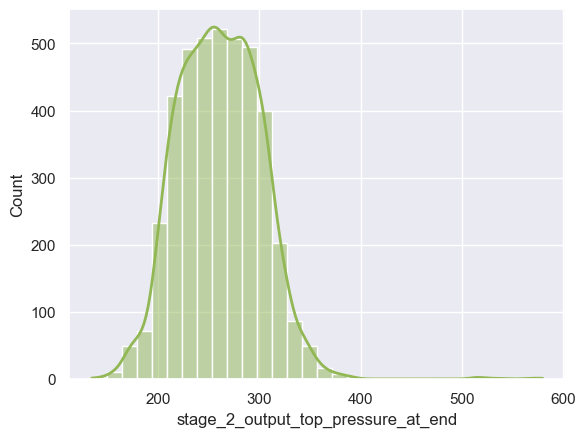

In [470]:
print(df['stage_2_output_top_pressure_at_end'].mean())
print(df['stage_2_output_top_pressure_at_end'].median())
sns.histplot(df['stage_2_output_top_pressure_at_end'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [471]:
df['stage_2_output_top_pressure_at_end'] = df['stage_2_output_top_pressure_at_end'].fillna(df['stage_2_output_top_pressure_at_end'].mean())

'stage_2_output_top_pressure' - давление верха (top) в агрегате, в кПа  
Распределение не нормальное - используем медиану 

448.2135656441718
435.62


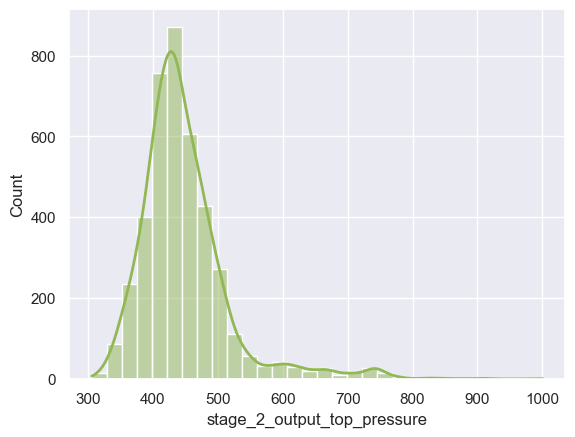

In [472]:

print(df['stage_2_output_top_pressure'].mean())
print(df['stage_2_output_top_pressure'].median())
sns.histplot(df['stage_2_output_top_pressure'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [473]:
df['stage_2_output_top_pressure'] = df['stage_2_output_top_pressure'].fillna(df['stage_2_output_top_pressure'].median())

'stage_2_output_bottom_vacuum' - вакуум низа в агрегате, в кПа  
Распределение не нормальное - используем медиану 

56.655807654075545
56.075


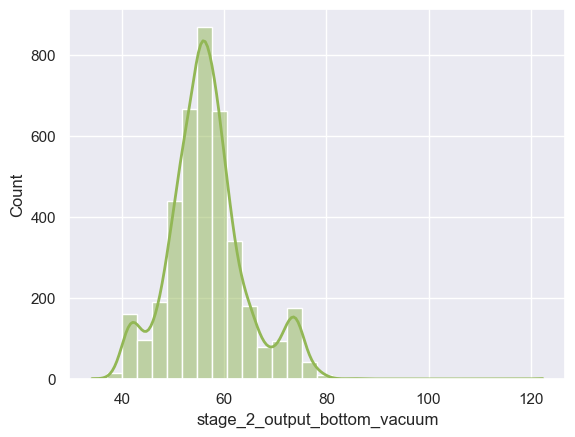

In [474]:

print(df['stage_2_output_bottom_vacuum'].mean())
print(df['stage_2_output_bottom_vacuum'].median())
sns.histplot(df['stage_2_output_bottom_vacuum'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [475]:
df['stage_2_output_bottom_vacuum'] = df['stage_2_output_bottom_vacuum'].fillna(df['stage_2_output_bottom_vacuum'].median())

'stage_2_output_bottom_temp_hum_steam' - температура насыщенного пара низа в агрегате, в градусах Цельсия  
Распределение не нормальное - используем медиану 

98.3794068627451
96.96


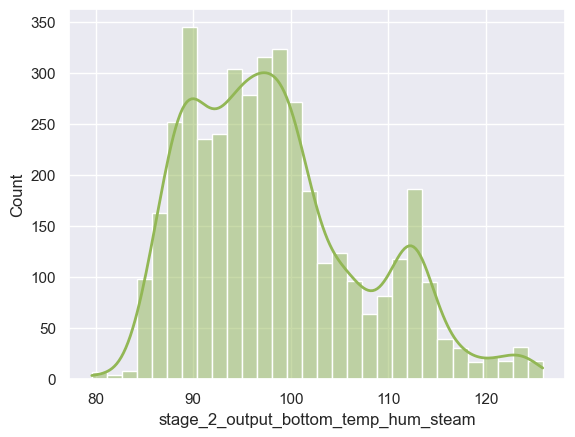

In [476]:
print(df['stage_2_output_bottom_temp_hum_steam'].mean())
print(df['stage_2_output_bottom_temp_hum_steam'].median())
sns.histplot(df['stage_2_output_bottom_temp_hum_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [477]:
df['stage_2_output_bottom_temp_hum_steam'] = df['stage_2_output_bottom_temp_hum_steam'].fillna(df['stage_2_output_bottom_temp_hum_steam'].median())

'stage_2_output_bottom_temp' - температура низа в агрегате, в градусах Цельсия  
Распределение нормальное - используем среднее

79.09006397637796
78.75


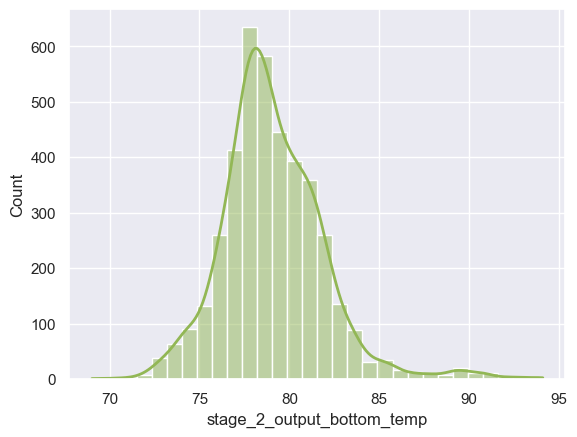

In [478]:
print(df['stage_2_output_bottom_temp'].mean())
print(df['stage_2_output_bottom_temp'].median())
sns.histplot(df['stage_2_output_bottom_temp'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [479]:
df['stage_2_output_bottom_temp'] = df['stage_2_output_bottom_temp'].fillna(df['stage_2_output_bottom_temp'].mean())

'stage_2_output_bottom_pressure' - давление низа (bottom) в агрегате, в кПа  
Распределение не нормальное - используем медиану 

402.7377254707631
387.105


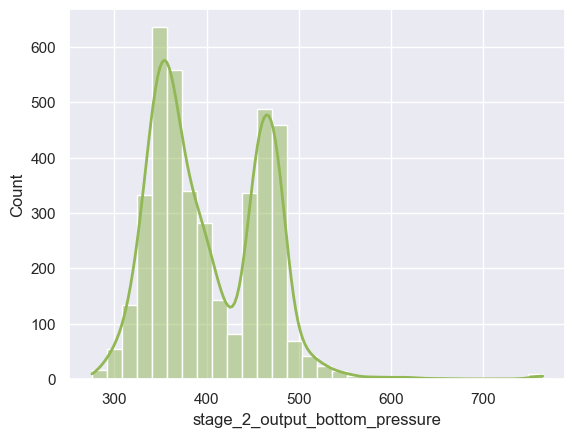

In [480]:
print(df['stage_2_output_bottom_pressure'].mean())
print(df['stage_2_output_bottom_pressure'].median())
sns.histplot(df['stage_2_output_bottom_pressure'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [481]:
df['stage_2_output_bottom_pressure'] = df['stage_2_output_bottom_pressure'].fillna(df['stage_2_output_bottom_pressure'].median())

'stage_2_input_water_sum' - количество подаваемой суммарной воды в агрегат, в м3.  
Распределение не нормальное - используем медиану 

86.99740951908777
83.08500000000001


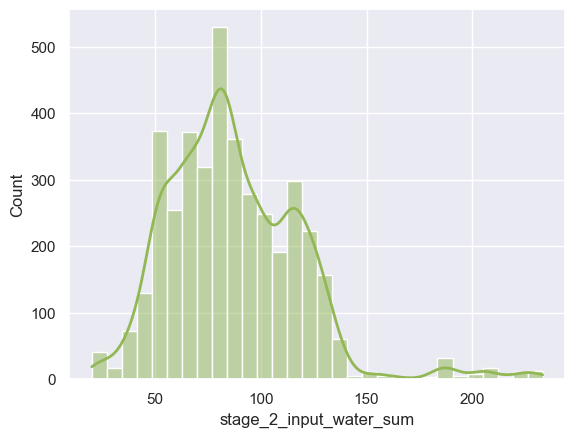

In [482]:
print(df['stage_2_input_water_sum'].mean())
print(df['stage_2_input_water_sum'].median())
sns.histplot(df['stage_2_input_water_sum'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [483]:

df['stage_2_input_water_sum'] = df['stage_2_input_water_sum'].fillna(df['stage_2_input_water_sum'].median())

'stage_1_output_konv_avd' - процент конверсии сырья в мономер.  
Различия медианы и среднего мало, распределение выглядит почти нормальным, можно брать и среднее и медиану

69.62783582089553
70.23


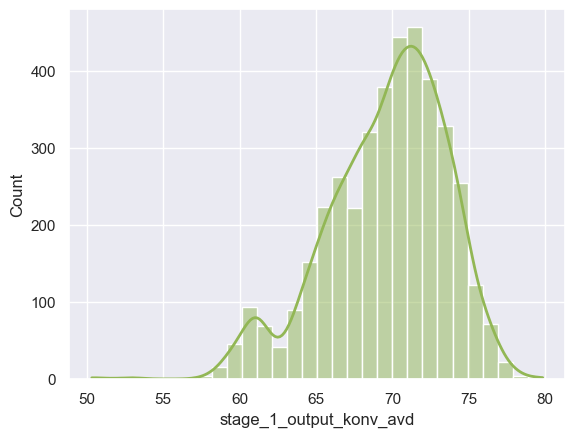

In [484]:
print(df['stage_1_output_konv_avd'].mean())
print(df['stage_1_output_konv_avd'].median())
sns.histplot(df['stage_1_output_konv_avd'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [485]:
df['stage_1_output_konv_avd'] = df['stage_1_output_konv_avd'].fillna(df['stage_1_output_konv_avd'].mean())

## Проведение расчётов

### Категория опасности 

In [486]:
df['danger_gas_kat'] = df['stage_4_output_danger_gas'].apply(
    lambda x: None if pd.isna(x) else (1 if x < 0.05 else (2 if x < 0.16 else 3))
)

df.columns

Index(['datetime', 'stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift', 'danger_gas_kat'],
      dtype='object')

###  Cводная таблица изменения параметров сгруппированная по дням 

In [487]:
df['input_water_sum'] = df['stage_2_input_water_sum'] + df['stage_4_input_water'] + df['stage_3_input_soft_water']
df['input_steam_sum'] = df['stage_4_input_steam'] + df['stage_3_input_steam']

columns_to_sum = ['stage_4_input_overheated_steam', 'stage_4_input_polymer', 'input_water_sum', 'input_steam_sum']

pivot_df = df.groupby('datetime')[columns_to_sum].sum()

pressure_avg = df.groupby('datetime')['stage_3_input_pressure'].mean().reset_index()
pivot_df = pd.merge(pivot_df, pressure_avg, on='datetime', how='left')
df.drop(columns=['input_water_sum', 'input_steam_sum'], inplace=True, axis=1)
pivot_df

,datetime,stage_4_input_overheated_steam,stage_4_input_polymer,input_water_sum,input_steam_sum,stage_3_input_pressure
0,2021-01-28,938.81,117.74,5201.46,4265.89,0.348333
1,2021-01-29,2661.56,312.33,14085.26,11674.59,0.352353
2,2021-01-30,784.46,113.96,4587.81,4163.24,0.404000
3,2021-01-31,2193.40,356.29,13584.48,12648.82,0.384286
4,2021-02-01,2352.30,350.65,14560.40,12277.10,0.378667
...,...,...,...,...,...,...
366,2023-03-17,304.02,38.45,1103.38,1046.11,0.365000
367,2023-03-18,153.93,17.02,667.12,418.11,0.540000
368,2023-03-19,152.90,22.69,531.71,451.57,0.460000
369,2023-03-20,305.06,43.16,1130.31,1069.08,0.360000


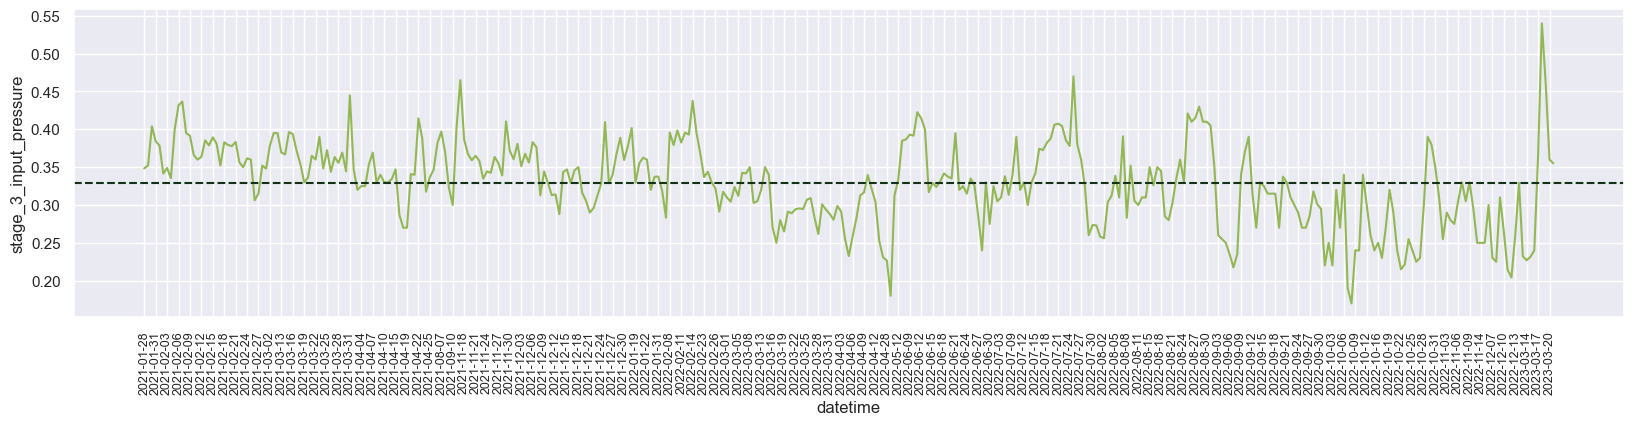

In [488]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_3_input_pressure', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_3_input_pressure'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

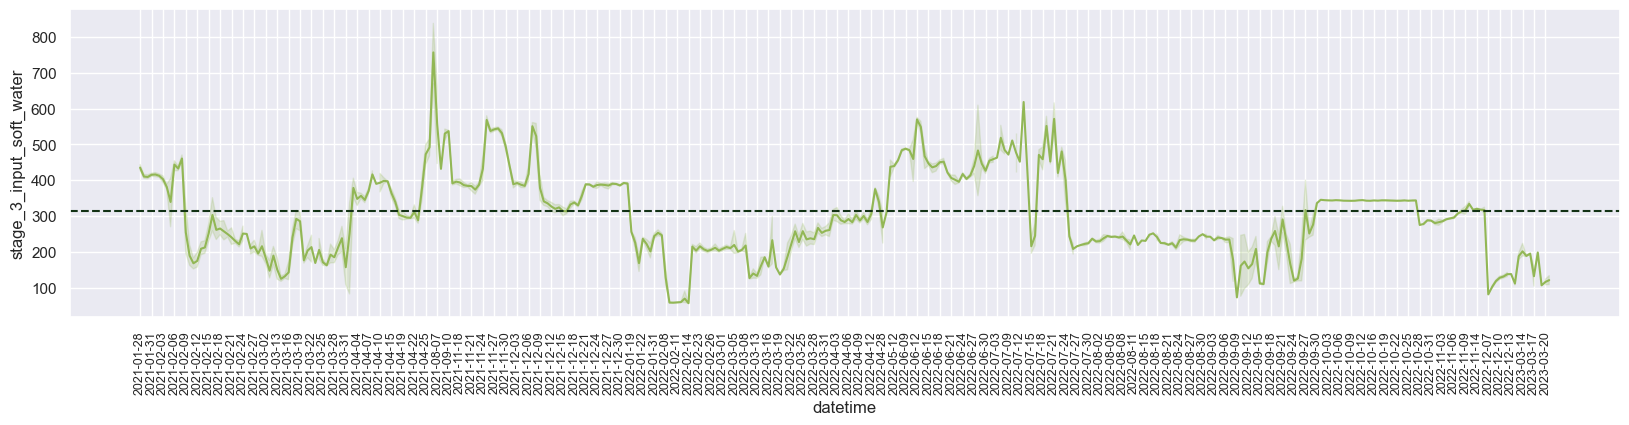

In [489]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_3_input_soft_water', data=df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = df['stage_3_input_soft_water'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

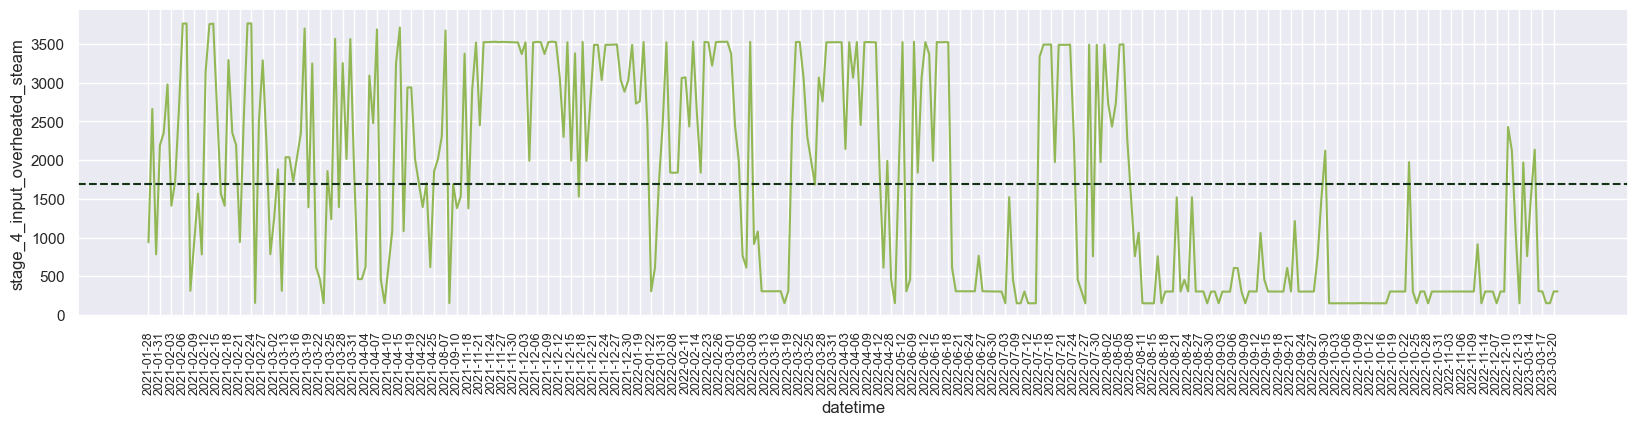

In [490]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_4_input_overheated_steam', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_4_input_overheated_steam'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

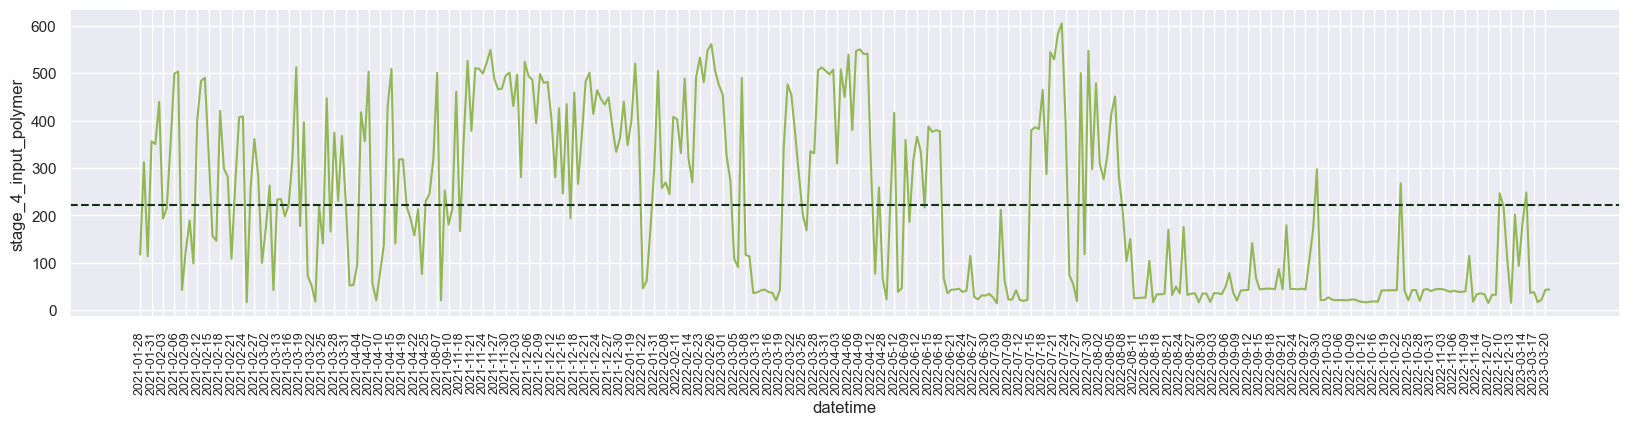

In [491]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_4_input_polymer', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_4_input_polymer'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

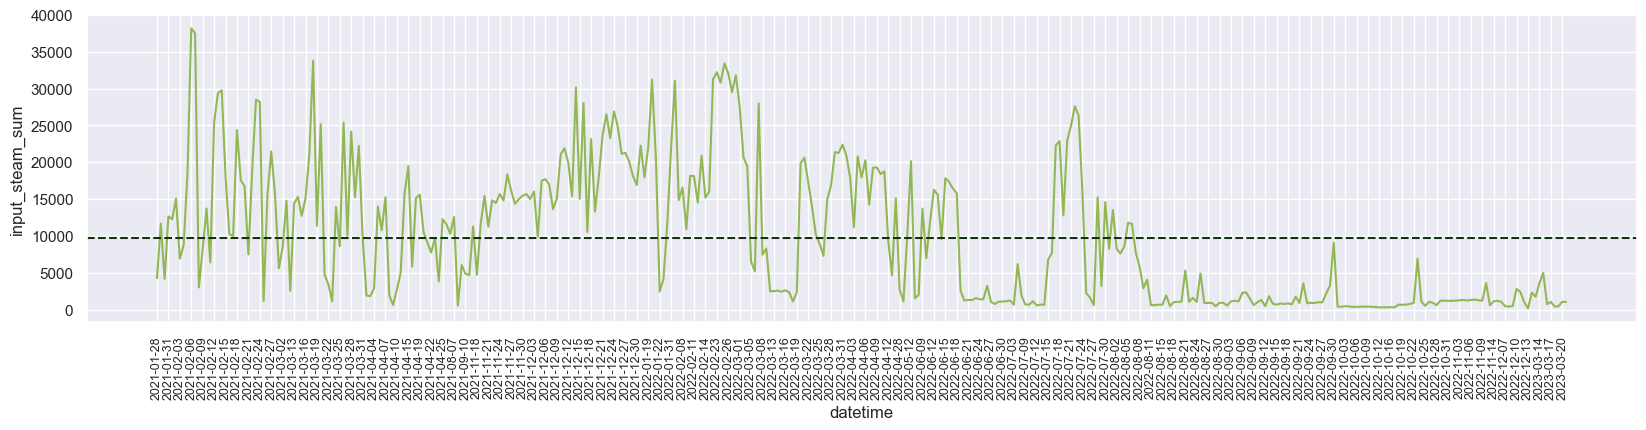

In [492]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='input_steam_sum', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['input_steam_sum'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

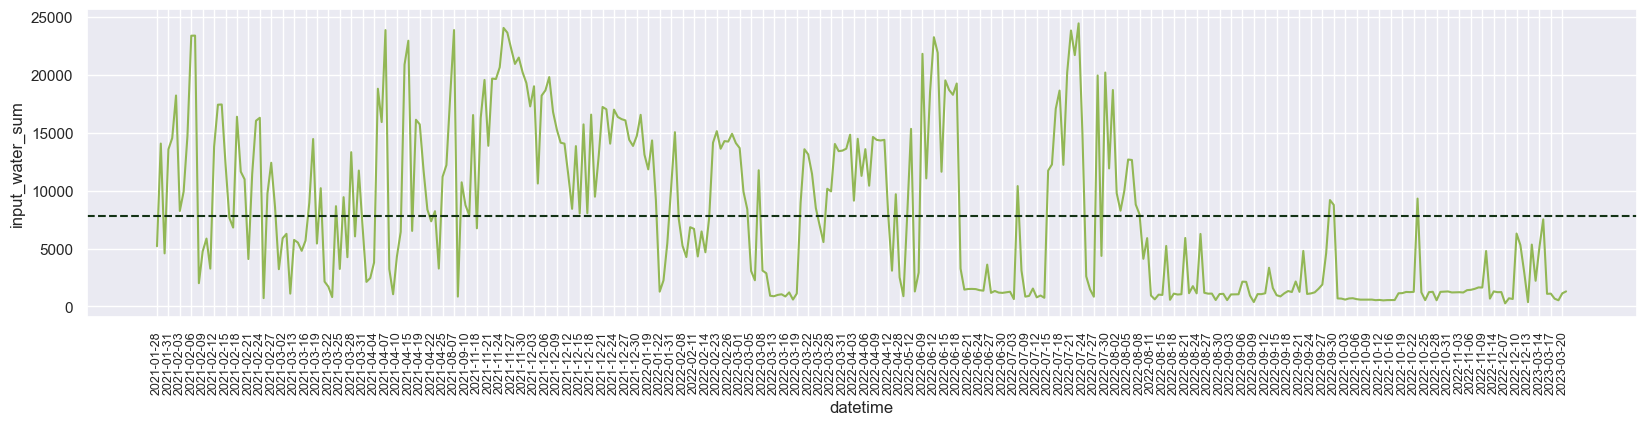

In [493]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='input_water_sum', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3])

plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['input_water_sum'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

### Cводная таблица изменения категории опасности сгруппированная по месяцам

Обработаем даты

In [494]:
df['datetime'] = df['datetime'].apply(lambda x: x[:-3])

In [495]:
for_table_df = df[['datetime', 'danger_gas_kat']]

for_table_df = for_table_df.groupby(['datetime'], as_index=False).value_counts()
pivot_table = for_table_df.pivot_table(index='datetime', aggfunc=mode)
pivot_table['danger_gas_kat'] = pivot_table['danger_gas_kat'].astype('int')
pivot_table

,count,danger_gas_kat
datetime,,
2021-01,5,2
2021-02,50,2
2021-03,59,2
2021-04,33,2
2021-08,8,2
2021-09,3,2
2021-11,32,2
2021-12,54,3
2022-01,11,3


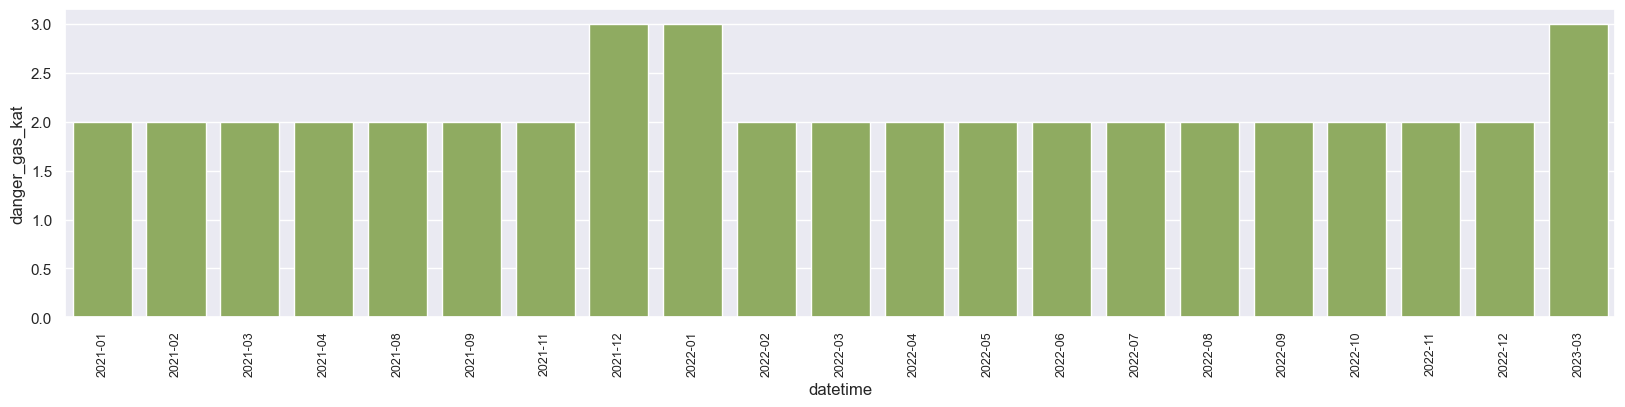

In [496]:
plt.figure(figsize=(20, 4))

graph = sns.barplot(x='datetime', y='danger_gas_kat', data=pivot_table, color=color_for_histplot)

plt.xticks(rotation=90)
plt.xticks(fontsize=9)
plt.show()

Наибольшая опасность была в период с 2021.12 - 2022.01 и 2023.03

### Среднее значение каждого параметра для каждой категории

In [497]:
curr_df = df.copy()

curr_df.drop(['datetime', 'work_shift'], axis=1, inplace=True)

group = curr_df.groupby(['danger_gas_kat']).mean()
group

,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,stage_2_output_top_vacuum,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product
danger_gas_kat,,,,,,,,,,,,,,,,,,,,,
1.0,65.830000,80.640000,383.996000,78.536000,101.944000,56.360000,450.904000,266.380000,93.890000,58.212000,...,756.620000,109.586000,41.268000,153.314000,18.092000,4.612000,232.050000,0.036000,21.800000,43.484000
2.0,68.952998,87.750008,394.795946,79.060543,98.293372,56.631209,458.169589,262.249931,94.345921,59.373380,...,815.834581,109.372755,42.216957,153.348470,20.078684,5.221941,297.206595,0.119079,22.222434,44.234852
3.0,69.334334,86.440405,395.548645,78.734642,97.468785,56.708022,443.590717,263.886760,94.927040,56.921698,...,837.982150,109.970202,42.493520,153.236044,20.155358,5.592835,312.431994,0.181651,22.525171,42.330779


### Корреляционный анализ

<Axes: >

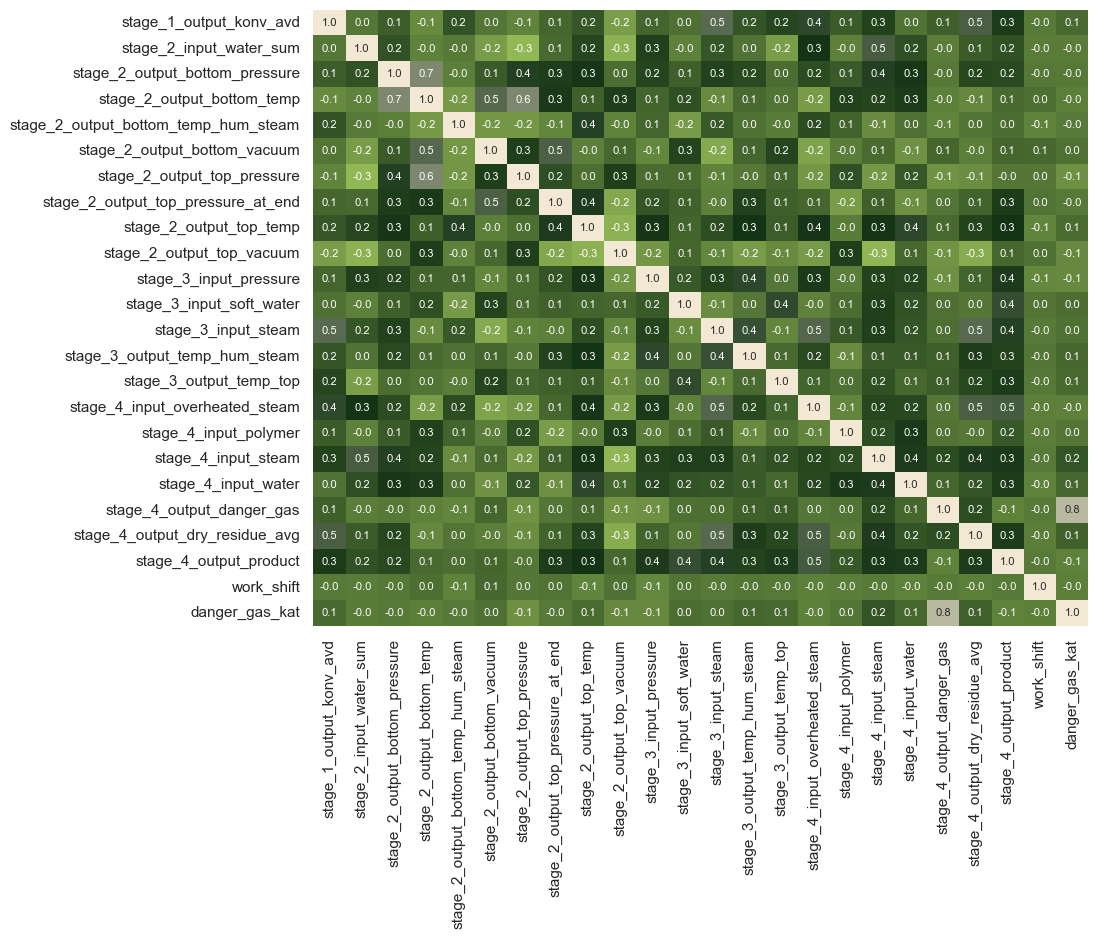

In [499]:
df_filtered = df.dropna(subset=['stage_4_output_danger_gas'])
custom_gradient = LinearSegmentedColormap.from_list("CorporateGradient", corporate_colors)
spec_df = df_filtered.drop('datetime', axis=1)
correlation_matrix = spec_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap=custom_gradient, fmt='.1f', cbar=False, annot=True, annot_kws={"size": 8})

## Проверка гипотез

### Гипотеза 1. Если ли различия в доле опасного газа от смены?

### Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3?

### Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.

### Гипотеза 4. Количество выходного количества продукта связано с долей опасного газа

### Гипотеза 5

### Гипотеза 6

### Гипотеза 7

### Гипотеза 8

## Регрессионное моделирование

### Моделирование для доли опасного газа